# First steps in Spotify Top50
---
Import necessary libraries for data analysis and plotting.

In [1]:
import pandas as pd
from custom_func import plot_scatter_with_stats, correl_heat_map

---

Read dataset from csv file located in the working directory, and set the included index column as index for the DataFrame.

In [2]:
data = pd.read_csv("spotifytoptracks.csv", index_col=0)
safety_copy = data.copy(deep=True)

---

Have a rough look at the dataset.

In [3]:
data.head()

,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre
0,The Weeknd,After Hours,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.730,0.514,1,-5.934,0.00146,0.0598,0.000095,0.0897,0.334,171.005,200040,R&B/Soul
1,Tones And I,Dance Monkey,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,0.593,0.825,6,-6.401,0.68800,0.0988,0.000161,0.1700,0.540,98.078,209755,Alternative/Indie
2,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,0.586,0.896,10,-6.687,0.10400,0.0559,0.000000,0.7900,0.642,116.971,196653,Hip-Hop/Rap
3,SAINt JHN,Roses (Imanbek Remix),Roses - Imanbek Remix,2Wo6QQD1KMDWeFkkjLqwx5,0.721,0.785,8,-5.457,0.01490,0.0506,0.004320,0.2850,0.894,121.962,176219,Dance/Electronic
4,Dua Lipa,Future Nostalgia,Don't Start Now,3PfIrDoz19wz7qK7tYeu62,0.793,0.793,11,-4.521,0.01230,0.0830,0.000000,0.0951,0.679,123.950,183290,Nu-disco


---

## Data cleaning

### Check for missing values.

In [4]:
data.isna().any(axis = None)

np.False_

None of the Data in the DataFrame is null.

I decided not to drop any of the cells in case of missing values, because this is a very limited dataset with emphasis on the amount of rows, as it is a top list. 

If there were empty cells in the DataFrame:

In [5]:
data.fillna("N/A", inplace=True)

---

### Check for duplicates in the DataFrame.

In [6]:
data.duplicated().any(axis=None)

np.False_

No duplicate in the data. 

If there were any duplicates:

In [7]:
data.drop_duplicates(inplace=True)

---

### Detecting outliers by testing z-score:

The outlier threshold value is chosen as 3.0, meaning that 99.7% of the data points lie between +/- 3 standard deviation from the mean.

<img src="bell.jpg" height="250">

Filtering the numeric features into a new DataFrame, as it is only possible for these to calculate the numeric statistical characteristics. 


In [8]:
num_cols = data.select_dtypes('number').columns
numeric_data = data.loc[:, num_cols]


Calculating the limit for each feature and checking if the difference of the values from the mean is within the tolerance of 3 standard deviations. 

The result is a bool DataFrame of the same structure as the filtered numerical data.

In [9]:
lim = abs((numeric_data - numeric_data.mean())/numeric_data.std(ddof = 0)) <3

Filtering the dataset to check if the row has any outliers.

If it does, it gets indicated in the bool Series called filter, which then filters the whole, original dataset to retrieve the records that have outliers.

In [10]:
filter = lim.all(axis = 1)
outlier_records = data.copy()[~filter]
outlier_records

,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre
2,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,0.586,0.896,10,-6.687,0.10400,0.0559,0.00000,0.790,0.642,116.971,196653,Hip-Hop/Rap
19,Future,High Off Life,Life Is Good (feat. Drake),1K5KBOgreBi5fkEHvg5ap3,0.574,0.795,2,-6.903,0.06700,0.4870,0.00000,0.150,0.537,142.053,237918,Hip-Hop/Rap
24,Billie Eilish,everything i wanted,everything i wanted,3ZCTVFBt2Brf31RLEnCkWJ,0.225,0.704,6,-14.454,0.90200,0.0994,0.65700,0.106,0.243,120.006,245426,Pop
41,Black Eyed Peas,Translation,RITMO (Bad Boys For Life),4NCsrTzgVfsDo8nWyP8PPc,0.704,0.723,10,-7.088,0.02590,0.0571,0.00109,0.792,0.684,105.095,214935,Pop
49,Travis Scott,ASTROWORLD,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,0.730,0.834,8,-3.714,0.00513,0.2220,0.00000,0.124,0.446,155.008,312820,Hip-Hop/Rap


If we want to check which values are outliers, we can use the lim bool DataFrame to filter.

This way we can display the index and the feature where the value is outside of the tolerance.


What to do with this information is up to the requirements.

In [11]:
outlier_items = numeric_data[~lim]
outlier_items = outlier_items.dropna(how='all').dropna(axis = 1, how='all')

Creating a stack of outlier items and extracting the index, value pairs to display in the output in text form.

In [12]:
from operator import le


outlier_stack = outlier_items.stack().reset_index().set_index("level_1")
outlier_df=pd.DataFrame(outlier_stack).rename(columns={"level_0": "at_index", 0: "value"}).rename_axis("feature")
outlier_df.sort_index()

,at_index,value
feature,,
duration_ms,49,312820.000
instrumentalness,24,0.657
liveness,2,0.790
liveness,41,0.792
loudness,24,-14.454
speechiness,19,0.487


Creating scatter plots for visualization of the values, the outliers and the tolerance zone for each feature that has outliers.

Also printing the outlier values in sentences for better understanding with the z-score. 

$$
z = \frac{data-mean}{standard\ deviation}\
$$

The z-score for the outliers will be bigger than 3, because that is the conventional limit that I worked with (meaning: 99,7% of the data is within tolerance). 

The user can get a sense how much of a deviation there is based on the score. 

Outlier in feature 'loudness' at index 24: -14.454 (z-score: -3.5017)


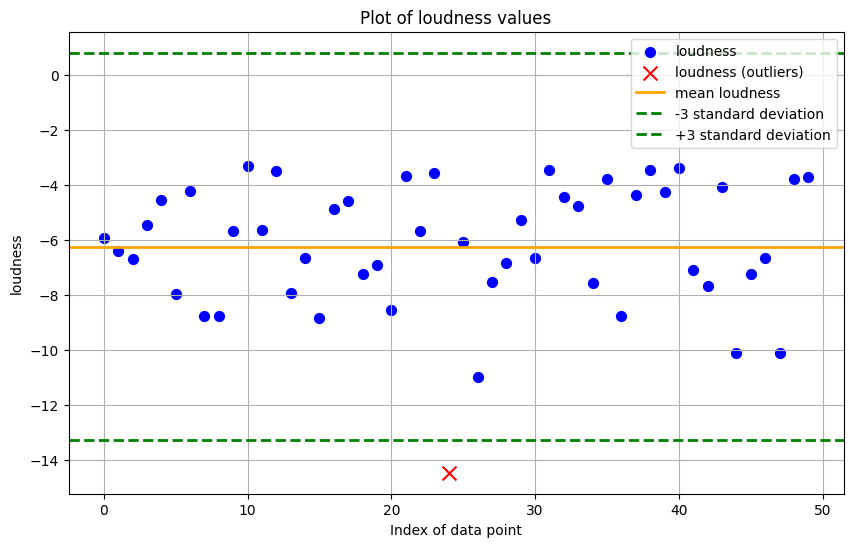

Outlier in feature 'speechiness' at index 19: 0.487 (z-score: 3.1056)


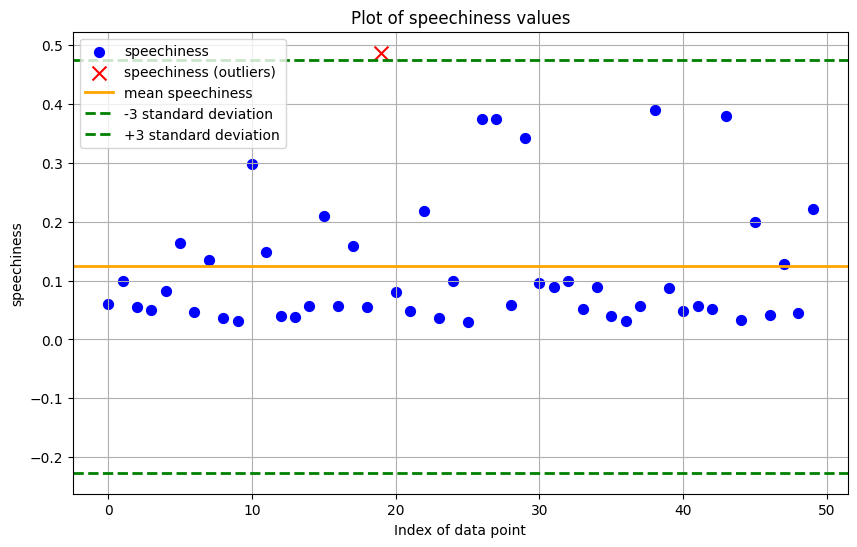

Outlier in feature 'instrumentalness' at index 24: 0.657 (z-score: 6.7970)


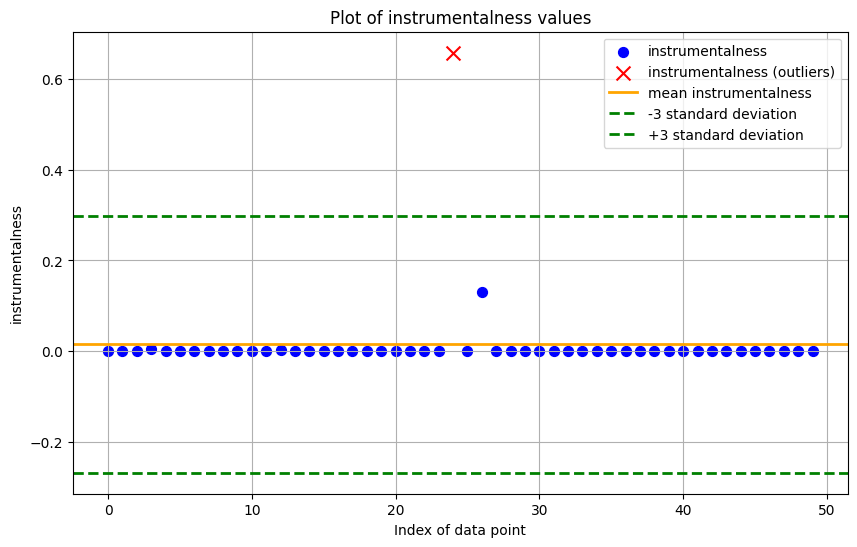

Outlier in feature 'liveness' at index 2: 0.79 (z-score: 3.3602)
Outlier in feature 'liveness' at index 41: 0.792 (z-score: 3.3715)


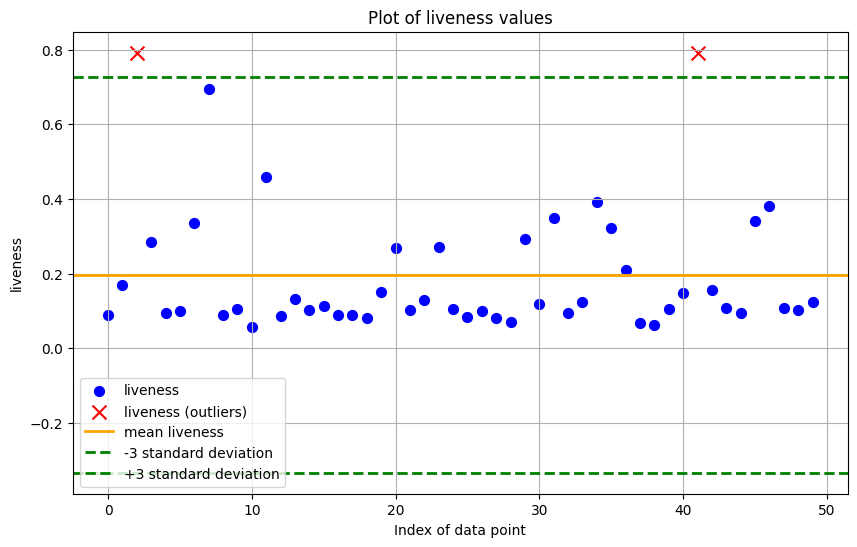

Outlier in feature 'duration_ms' at index 49: 312820.0 (z-score: 3.3199)


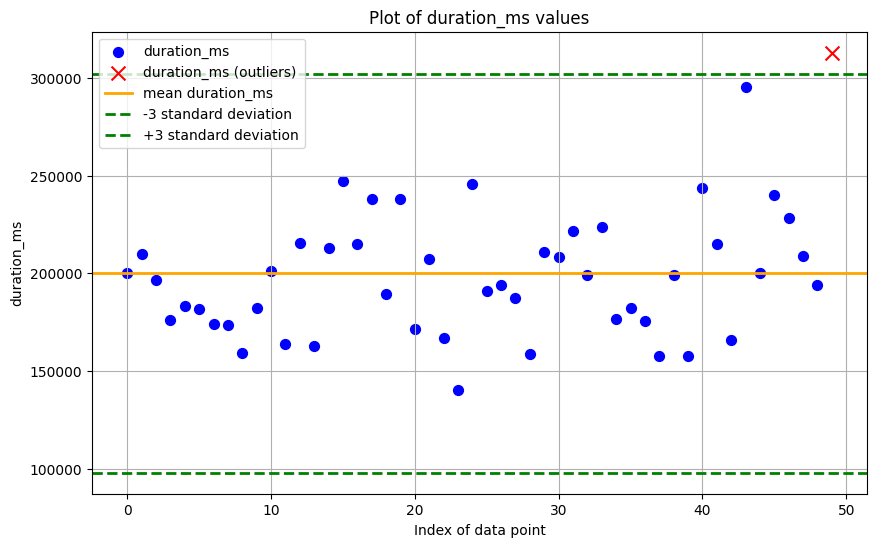

In [14]:
columns_to_keep = ~lim.all()

to_plot = data[num_cols].loc[:, columns_to_keep]
    
for feature in to_plot:
    plot_scatter_with_stats(to_plot, outlier_df, feature)

The outliers here can all be considered "fun facts" as the data is valid, it is just a statistical fact, that they are outliers, and do not need to be removed.

It could also be an explanation, that the data set is small, and in case of a large data set they might not even be outliers.

For example we could detect an extremely short song that was maybe not completely uploaded or is just a demo using this method.

---

## Exploratory data analysis

### Number of observations (rows/records): 

In [15]:
data.index.size


50

---

### Number of features (columns):

In [16]:
data.columns.size


16

---

### Which of the features are categorical (not numeric) and which are numeric?

In [17]:
numeric = data.dtypes[data.select_dtypes('number').columns].index.drop("key")
categorical = data.columns.drop(numeric)
print("Numeric features: " + ", ".join(numeric))
print("Categorical features: " + ", ". join(categorical.drop("track_id")))

Numeric features: energy, danceability, loudness, acousticness, speechiness, instrumentalness, liveness, valence, tempo, duration_ms
Categorical features: artist, album, track_name, key, genre


After checking the kaggle website (source for this dataset), it turned out that even though 'key' is an integer, it is actually a categorical feature, so it had to be handled separately.

Track_id is a random combination of chars and numbers, so it does not make sense to consider it categorical, as it is not going to repeat itself like a track_name (song title) could.

---

### Are there any artists that have more than 1 popular track? If yes, which and how many?

In [18]:
artist_occurence = data["artist"].value_counts()
multiple_occurence = artist_occurence[artist_occurence > 1].index
artist_occurence[multiple_occurence].rename("multiple hits")


artist
Dua Lipa         3
Billie Eilish    3
Travis Scott     3
Harry Styles     2
Lewis Capaldi    2
Justin Bieber    2
Post Malone      2
Name: multiple hits, dtype: int64

---

### Who was the most popular artist?

Based on what? I am going with the one that has the top song of the list.

In [19]:
winner = data['artist'][0]
print(winner)

The Weeknd


---

### How many artists in total have their songs in the top 50?


In [20]:
data["artist"].unique().size


40

---

### Are there any albums that have more than 1 popular track? If yes, which and how many?

In [21]:
albums = data['album'].value_counts()
a_filter = albums[albums > 1].index
print(f'{albums[a_filter].size} albums have more than one popular track.')
albums[a_filter].rename("Recurring albums")

4 albums have more than one popular track.


album
Future Nostalgia        3
Hollywood's Bleeding    2
Fine Line               2
Changes                 2
Name: Recurring albums, dtype: int64

---
### How many albums in total have their songs in the top 50?

In [22]:
albums.index.unique().size


45

---

### Which tracks have a danceability score above 0.7?


In [23]:
data[["track_name", "danceability"]][data["danceability"] > 0.7].sort_values("danceability", ascending=False)


,track_name,danceability
27,WAP (feat. Megan Thee Stallion),0.935
2,The Box,0.896
39,Ride It,0.880
28,Sunday Best,0.878
33,Supalonely (feat. Gus Dapperton),0.862
40,goosebumps,0.841
49,SICKO MODE,0.834
15,Toosie Slide,0.830
1,Dance Monkey,0.825
29,Godzilla (feat. Juice WRLD),0.808


---

### Which tracks have a danceability score below 0.4?


In [24]:
data[["track_name", "danceability"]][data["danceability"] < 0.4].sort_values("danceability", ascending=False)


,track_name,danceability
44,lovely (with Khalid),0.351


---

### Which tracks have their loudness above -5?


In [25]:
data[["track_name", "loudness"]][data['loudness']> -5].sort_values("loudness", ascending=False)


,track_name,loudness
10,Tusa,-3.280
40,goosebumps,-3.370
31,Break My Heart,-3.434
38,Hawái,-3.454
12,Circles,-3.497
23,Mood (feat. iann dior),-3.558
21,Adore You,-3.675
49,SICKO MODE,-3.714
48,Physical,-3.756
35,Rain On Me (with Ariana Grande),-3.764


---

### Which tracks have their loudness below -8?


In [26]:
data[["track_name", "loudness"]][data['loudness'] < -8].sort_values("loudness", ascending=False)


,track_name,loudness
20,Savage Love (Laxed - Siren Beat),-8.520
8,Falling,-8.756
36,HIGHEST IN THE ROOM,-8.764
7,death bed (coffee for your head),-8.765
15,Toosie Slide,-8.820
47,If the World Was Ending - feat. Julia Michaels,-10.086
44,lovely (with Khalid),-10.109
26,bad guy,-10.965
24,everything i wanted,-14.454


---

### Which track is the longest?


In [27]:
longest_track = data["track_name"][data["duration_ms"].idxmax()]
print(longest_track)

SICKO MODE


---

### Which track is the shortest?


In [28]:
shortest_track = data["track_name"][data["duration_ms"].idxmin()]
print(shortest_track)

Mood (feat. iann dior)


---

### Which genre is the most popular?


In [29]:
genres = data.genre
top_genre = genres.value_counts().idxmax()
print(top_genre)

Pop


---

### Which genres have just one song on the top 50?


In [46]:
flat_genres = genres.str.split(pat="/", expand=True).to_numpy().flatten()
split_genres=pd.Series(flat_genres)
split_genres_values = split_genres.value_counts()
split_genres_list = split_genres_values.loc[split_genres.value_counts().values == 1].index.to_list()
print('\n'.join(split_genres_list))

Nu-disco
Hip-Hop alternative
Soft Rock
Pop rap
Trap
Dance-pop
Disco
Disco-pop
Dreampop
reggaeton
experimental
Chamber pop


Simply counting the unique values without splitting gives a false result.

In [31]:
one_hit_genres = genres.value_counts()[(genres.value_counts().values == 1)].index.to_list()
print('\n'.join(one_hit_genres))

R&B/Hip-Hop alternative
Nu-disco
Pop/Soft Rock
Pop rap
Hip-Hop/Trap
Dance-pop/Disco
Disco-pop
Dreampop/Hip-Hop/R&B
Alternative/reggaeton/experimental
Chamber pop


---

### How many genres in total are represented in the top 50?

I split the mixed genres by '/' character and then counted the unique values.


In [32]:
pd.unique(flat_genres).size

23

If I only count the unique values without splitting, we get a false result.

In [33]:
genres.unique().size


16

---

## Questions related to correlation

Creating the correlation matrix for the numerical features in the DataFrame.

Also creating a heatmap to visualize the correlation matrix.

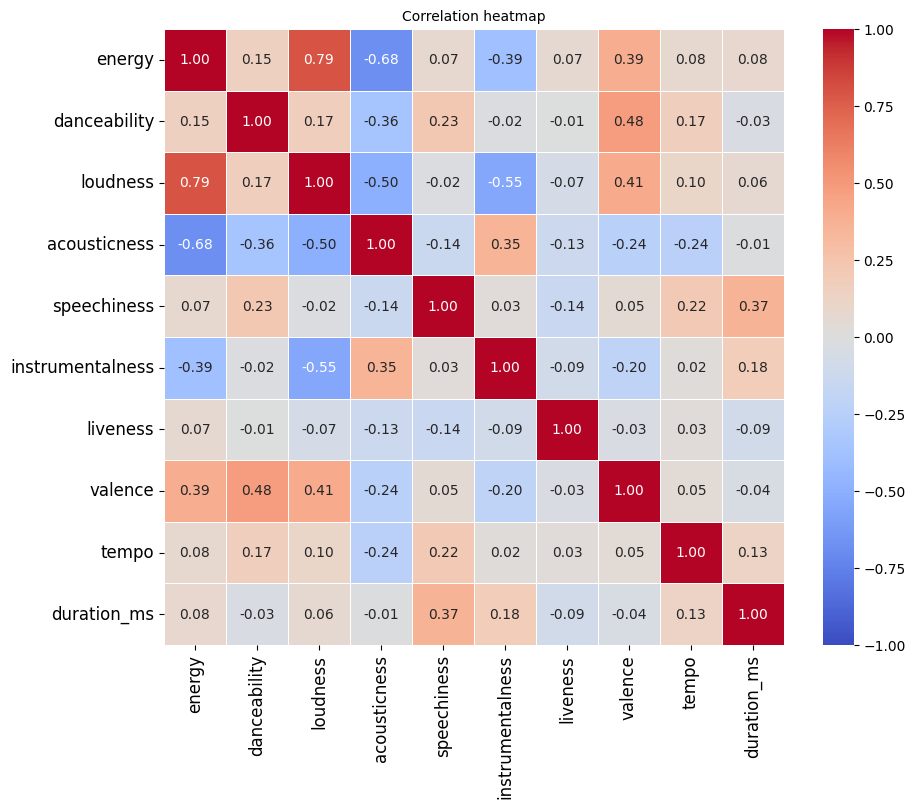

In [34]:
corr_m = data[numeric].corr()
correl_heat_map(corr_m)

### Which features are strongly positively correlated? (0.5 - 1.0)

Strong positive correlation means that if of one of the values increases, the correlated feature's value does as well in a significant manner.

Displaying the relevant part of the correlation matrix, and extracting the data to print the result in text form without duplicates.

In [35]:
pos_filter = (corr_m >= 0.5) & (corr_m < 1)
pos = corr_m[pos_filter].dropna(how='all').dropna(axis = 1, how = 'all')
print(pos)
print("\n")

correlated_tags = []
for row in pos.index:
    for col in pos.columns:
        if pd.notna(pos.loc[row, col]):
            if (col, row) not in correlated_tags and (row, col) not in correlated_tags:
                correlated_tags.append((row, col))

for tag in correlated_tags:
    row, col = tag
    print(f"Feature '{row}' and feature '{col}' are strongly positively correlated: {pos.loc[row, col]}")

           energy  loudness
energy        NaN   0.79164
loudness  0.79164       NaN


Feature 'energy' and feature 'loudness' are strongly positively correlated: 0.7916395653045617


This result could be used to handle the correlated features as a substitute for each other in case of missing data, e.g. if the energy feature is missing, we can assume that in case of a high loudness value we are not making a mistake by adding the record to a playlist called 'Energetic songs'.

### Which features are strongly negatively correlated? (-1.0 - -0.5)

Strong negative correlation means that if of one of the values increases, the correlated feature's value decreases in a significant manner.

Displaying the relevant part of the correlation matrix, and extracting the data to print the result in text form without duplicates.

In [36]:
neg_filter = (corr_m < -0.5)
neg = corr_m[neg_filter].dropna(how='all').dropna(axis = 1, how = 'all')
print(neg)
print('\n')

correlated_tags = []
for row in neg.index:
    for col in neg.columns:
        if pd.notna(neg.loc[row, col]):
            if (col, row) not in correlated_tags and (row, col) not in correlated_tags:
                correlated_tags.append((row, col))

for tag in correlated_tags:
    row, col = tag
    print(f"Feature '{row}' and feature '{col}' are strongly negatively correlated: {neg.loc[row, col]}")


                    energy  loudness  acousticness  instrumentalness
energy                 NaN       NaN     -0.682479               NaN
loudness               NaN       NaN           NaN         -0.553735
acousticness     -0.682479       NaN           NaN               NaN
instrumentalness       NaN -0.553735           NaN               NaN


Feature 'energy' and feature 'acousticness' are strongly negatively correlated: -0.6824785203241528
Feature 'loudness' and feature 'instrumentalness' are strongly negatively correlated: -0.5537348090851054


These results suggest that for example instrumental songs do not tend to be loud, and acoustic songs do not tend to be that energetic.

A conclusion could be, that since instrumental and acoustic songs usually have these as keywords in their titles, they can be ignored solely based on these words when making suggestions for a teenage party playlist, or the other way around, be top choices for café or meditation mixes. 

### Which features are not correlated? (-0.1 - 0.1)

Not correlated features do not display any major change as an effect of the change in value of the other feature.

Displaying the relevant part of the correlation matrix without values, and extracting the data to print the result in text form without duplicates (if text is needed, remove #).

In [37]:
neutral_filter = (corr_m <0.1) & (corr_m > -0.1)
neutral = corr_m[neutral_filter].dropna(how='all').dropna(axis = 1, how = 'all')

not_correlated_tags = []
for row in neutral.index:
    for col in neutral.columns:
        if not pd.notna(neutral.loc[row, col]):
            if (col, row) not in not_correlated_tags and (row, col) not in not_correlated_tags:
                not_correlated_tags.append((row, col))

# for tag in not_correlated_tags:
#     row, col = tag
#     print(f"Feature '{row}' and feature '{col}' are not in correlation.")
    

 ### Cells marked with 'x' are not in statistical correlation.

In [38]:
corr_m.where(neutral_filter, "-").where(~neutral_filter, "x")

,energy,danceability,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
energy,-,-,-,-,x,-,x,-,x,x
danceability,-,-,-,-,-,x,x,-,-,x
loudness,-,-,-,-,x,-,x,-,-,x
acousticness,-,-,-,-,-,-,-,-,-,x
speechiness,x,-,x,-,-,x,-,x,-,-
instrumentalness,-,x,-,-,x,-,x,-,x,-
liveness,x,x,x,-,-,x,-,x,x,x
valence,-,-,-,-,x,-,x,-,x,x
tempo,x,-,-,-,-,x,x,x,-,-
duration_ms,x,x,x,x,-,-,x,x,-,-


The result help understand which features do not influence each other in a significant manner.

For instance, the duration of the track does not influence its loudness.

---

## How does the danceability score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

I created the filters as variables, so it is easy to modify which genres and features we want to analyze.

First filtering the data required for the analysis: genres set as index for easier handling, and the relevant columns.

I grouped the DataFrame by genre, and created the columns for the statistical characteristics of each feature (mean, min, median, max, std) to be able to compare the genres.

In [39]:
genre_filter = ["Pop", "Hip-Hop/Rap", "Dance/Electronic", "Alternative/Indie"]
feature_filter = ["danceability", "loudness", "acousticness"]

comparison_base = data.set_index("genre").loc[genre_filter, feature_filter]
comparison = comparison_base.groupby("genre").agg([ 'mean', 'min', 'median', 'max', 'std'])

Defining a function to filter by feature and sort by given argument to avoid manual repetition. 

In [40]:
def filter_comparison(base, feature, sort_by):
    return base.loc[:, feature].sort_values(by = sort_by)

Retrieving the relevant column for the question and sorting by its mean values in ascending order.

In [41]:
filter_comparison(comparison, "danceability", "mean")


,mean,min,median,max,std
genre,,,,,
Alternative/Indie,0.661750,0.459,0.663,0.862,0.211107
Pop,0.677571,0.464,0.690,0.806,0.109853
Dance/Electronic,0.755000,0.647,0.785,0.880,0.094744
Hip-Hop/Rap,0.765538,0.598,0.774,0.896,0.085470


---

## How does the loudness score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

Retrieving the relevant column for the question and sorting by its mean values in ascending order.

In [42]:
filter_comparison(comparison, "loudness", "mean")


,mean,min,median,max,std
genre,,,,,
Hip-Hop/Rap,-6.917846,-8.820,-7.6480,-3.370,1.891808
Pop,-6.460357,-14.454,-6.6445,-3.280,3.014281
Alternative/Indie,-5.421000,-6.401,-5.2685,-4.746,0.774502
Dance/Electronic,-5.338000,-7.567,-5.4570,-3.756,1.479047


---

## How does the acousticness score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

Retrieving the relevant column for the question and sorting by its mean values in ascending order.

In [43]:
filter_comparison(comparison, "acousticness", "mean")


,mean,min,median,max,std
genre,,,,,
Dance/Electronic,0.099440,0.01370,0.0686,0.223,0.095828
Hip-Hop/Rap,0.188741,0.00513,0.1450,0.731,0.186396
Pop,0.323843,0.02100,0.2590,0.902,0.318142
Alternative/Indie,0.583500,0.29100,0.6460,0.751,0.204086


These comparisons can be used to suggest new genres to users based on these features.

If someone has a tendency to listen to music with a low loudness value, based on the data we could suggest other genres that they haven't listened to that also have a low loudness value. 

Best case would be considering multiple factors of the genres and make suggestions where the values of the most features are similar. 

---

## Checking if the original dataset remained intact.

In [44]:
(data == safety_copy).all(axis=None)

np.True_

The analysed dataset is the same as the safety copy, there weren't any accidental changes.

---

I would improve my code by specifying the requirements better to know what type of method to use to determine the outliers, and also what to do with them. 

I would also check if my methods and functions are applicable in a bigger, or just another dataset of the same shape, also if my solution is scalable and modular.

I would also check if my solution is fast enough, or is there a solution that is more efficient.